# Task 3 - Inductive Learning

**Project Team 9**

In [ ]:
import random
import os
import statistics
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import LSTM
import torch.nn.functional as F
import torch_geometric
import torch_scatter
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv, SAGEConv
from torch.utils.data import random_split
from torch_geometric.nn.pool import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.utils.dropout import dropout_edge
from torch.optim.lr_scheduler import ReduceLROnPlateau
from itertools import product
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from functools import partial
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch_geometric.datasets import TUDataset

In [ ]:
"""
!pip install torch_scatter
!pip install torch_geometric
!pip install pytorch_lightning
"""

In [ ]:
"""
Explore dataset
"""

dataset = TUDataset(name='ENZYMES', root='data/TUDataset')
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of edge attributes:{dataset.num_edge_attributes}')
print(f'Number of node attributes:{dataset.num_node_attributes}')

# Compute the number of non-zero features for each node
print('======================')
print("Statistics on non-zero features for each node")
num_features_per_node = dataset.x.gt(0).sum(dim=1)
display(pd.DataFrame(pd.Series(num_features_per_node).describe()).transpose().round(2)) # Summary statistics on node degrees

# Distribution of classes to investigate class imbalance
print('======================')
print("Statistics on class imbalance")
classes, counts = np.unique(dataset.y,return_counts=True)
display(pd.DataFrame({'classes': classes, 'counts': counts}))


Dataset: ENZYMES(600):
Number of graphs: 600
Number of features: 3
Number of classes: 6
Number of edge attributes:0
Number of node attributes:18
Statistics on non-zero features for each node


,count,mean,std,min,25%,50%,75%,max
0,19580.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Statistics on class imbalance


,classes,counts
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100
5,5,100


In [ ]:
"""
Explore sample graph
"""

data = dataset[0]  # Get the first (and only) graph object.

print(f"Sample graph: {data}")
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of avg. nodes: {np.mean([data.num_nodes for data in dataset]):.2f}')
print(f'Number of avg. edges: {np.mean([data.num_edges for data in dataset]):.2f}')

Sample graph: Data(edge_index=[2, 168], x=[37, 3], y=[1])
Number of avg. nodes: 32.63
Number of avg. edges: 124.27


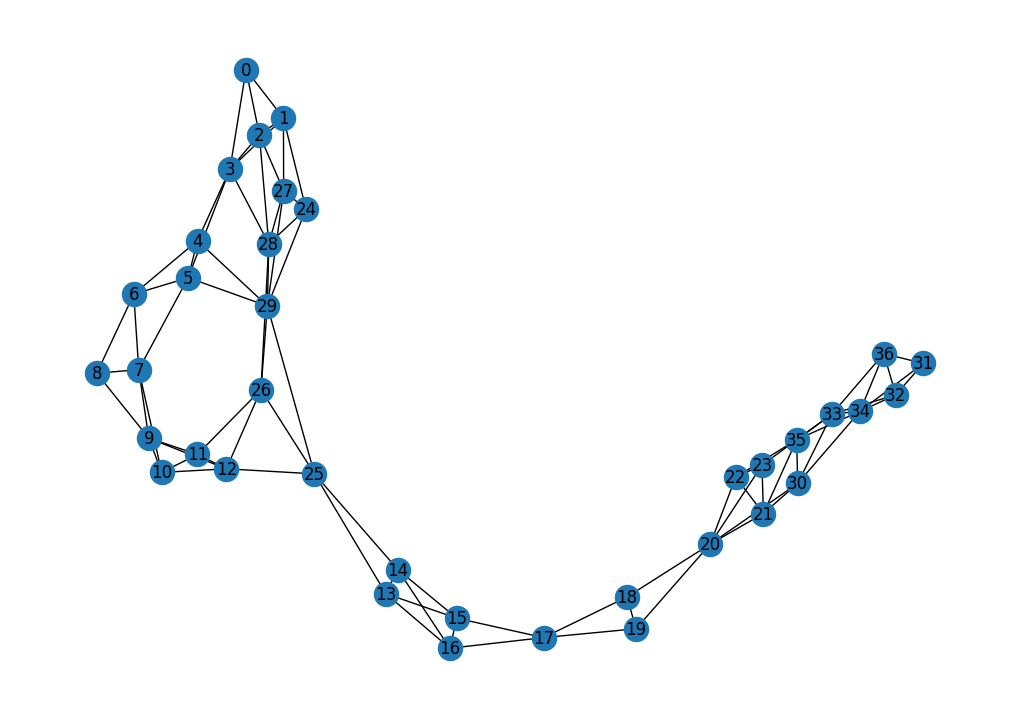

In [ ]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
"""
Define seed
"""

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class GNNWrapper(pl.LightningModule):
    """
    A Pytorch Lightning Wrapper to train
    sequence models (classifiers/regressors)
    """

    def __init__(self, dataset, model, learning_rate = 0.01, use_lr_scheduler = False, weight_decay = 0.0001,
                 schedule_patience = 20, use_node_attr = False, use_edge_attr = False) -> None:
        super().__init__()

        # Store the dataset and define loss
        self.data = dataset
        self.model = model
        self.loss = nn.CrossEntropyLoss()

        # Store hyperparameters
        self.use_node_attr = use_node_attr
        self.use_edge_attr = use_edge_attr
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.use_lr_scheduler = use_lr_scheduler
        self.patience = schedule_patience

        # Utility variables to track the training and validation loss/accuracy
        self.train_loss = []
        self.val_loss = []
        self.train_proba = []
        self.train_labels = []
        self.val_proba = []
        self.val_labels = []
        self.val_hidden = []
        self.val_hidden_plot_patience = 0
        self.epoch_train_loss = []
        self.epoch_train_accuracy = []
        self.epoch_val_loss = []
        self.epoch_val_accuracy = []

        self.save_hyperparameters(ignore=["model", "dataset"])

    def forward(self, x, edge_index, batch):
        """
        We define the forward pass of the model.
        """
        logits = self.model(x, edge_index, batch)
        return logits

    def compute_loss(self, logits, labels) -> torch.Tensor:
        """
        Loss computation, signal from the training nodes
        again for simplicity we consider all other nodes as validation nodes
        """
        # Task specific loss
        train_logits = logits
        train_labels = labels

        loss = self.loss(train_logits, train_labels)

        return loss

    def training_step(self, batch, batch_idx):
        """
        Define a single learning step
        """
        data = batch

        logits = self(data.x, data.edge_index, data.batch)
        loss = self.compute_loss(logits, data.y)

        train_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = data.y.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_proba.append(train_proba)
        self.train_labels.append(train_labels)

        return loss

    def on_train_epoch_end(self) -> None:
        """
        At the end of an epoch we compute and log metrics
        """
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_proba)
        train_labels = np.concatenate(self.train_labels)
        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.epoch_train_loss.append(train_loss)
        self.epoch_train_accuracy.append(train_acc)

        self.train_loss.clear()
        self.train_proba.clear()
        self.train_labels.clear()

    def validation_step(self, batch, batch_idx):
        """
        Define a validation step, here very similar to the training step
        For simplicity we consider all nodes not in the training set as validation nodes
        """
        data = batch

        logits = self(data.x, data.edge_index, data.batch)
        loss = self.compute_loss(logits, data.y)

        val_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = data.y.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_proba.append(val_proba)
        self.val_labels.append(val_labels)

    def on_validation_epoch_end(self) -> None:
        """
        Compute and log validation metrics, and visualize the hidden layers
        """
        val_loss = float(np.mean(self.val_loss))
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_proba)
        val_labels = np.concatenate(self.val_labels)
        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.epoch_val_loss.append(val_loss)
        self.epoch_val_accuracy.append(val_acc)


        self.val_loss.clear()
        self.val_proba.clear()
        self.val_labels.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )

        if self.use_lr_scheduler:
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=self.patience, min_lr=0.0001)
            return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'train/loss'
            }

        return optimizer


In [ ]:
def plot_results(results):
    fig, axes = plt.subplots(len(DATA_PERTURB_SEEDS), 2, figsize=(15, 5 * len(DATA_PERTURB_SEEDS)))

    for i, seed in enumerate(DATA_PERTURB_SEEDS):
            key = f"{seed}"
            metrics = results[key]
            epochs = range(1, len(metrics["train_loss"]) + 1)

            # Adjust epochs for the current metric's data
            epochs_for_val_loss = range(1, len(metrics["val_loss"]) + 1)

            # Plot training and validation loss on the left column
            axes[i][0].plot(epochs, metrics["train_loss"], 'b-', label='Train Loss')
            axes[i][0].plot(epochs_for_val_loss, metrics["val_loss"], 'r-', label='Validation Loss')
            axes[i][0].set_xlabel('Epochs')
            axes[i][0].set_ylabel('Loss')
            axes[i][0].legend()
            axes[i][0].set_title(f"Loss for seed {seed}")

            # Adjust epochs for accuracy data
            epochs_for_val_accuracy = range(1, len(metrics["val_accuracy"]) + 1)

            # Plot training and validation accuracy on the right column
            axes[i][1].plot(epochs, metrics["train_accuracy"], 'b-', label='Train Accuracy')
            axes[i][1].plot(epochs_for_val_accuracy, metrics["val_accuracy"], 'r-', label='Validation Accuracy')
            axes[i][1].set_xlabel('Epochs')
            axes[i][1].set_ylabel('Accuracy')
            axes[i][1].legend()
            axes[i][1].set_title(f"Accuracy for seed {seed}")

    plt.tight_layout()
    plt.show()

## 3.0 Simple model

In [ ]:
# Baseline model:

class GCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True):
        super(GCNBlock, self).__init__()

        self.conv = GCNConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class SimpleGCN(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(SimpleGCN, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

layer_configs = [
    {"in_channels": 64, "out_channels": 64, "dropout_rate": 0.5, "batch_norm": True}
]

In [ ]:
DATA_PERTURB_SEEDS = [123, 345, 567]  # 3 distinct seeds for data perturbations
train_size = 500
test_size = 100
batch_size = 128
learning_rate = 0.005
weight_decay = 0.001
scheduler = True
schedule_patience = 20

results = {}

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = SimpleGCN(dataset.num_features, layer_configs, dataset.num_classes)
    model_wrapper = GNNWrapper(dataset, model, learning_rate=learning_rate, use_lr_scheduler = scheduler,
                                schedule_patience = schedule_patience, weight_decay=weight_decay)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor=f"val/loss", mode="min", patience=50)

    # Instantiate Pytorch Lightning trainer
    trainer = pl.Trainer(
      accelerator="cpu",
      max_epochs=500,
      callbacks=[early_stopping],
      check_val_every_n_epoch=1,
    )

    # Train the model
    trainer.fit(model_wrapper, train_loader, test_loader)
    trainer.validate(model_wrapper, test_loader)

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": model_wrapper.epoch_train_loss,
        "train_accuracy": model_wrapper.epoch_train_accuracy,
        "val_loss": model_wrapper.epoch_val_loss,
        "val_accuracy": model_wrapper.epoch_val_accuracy,
        "best_val_accuracy": max(model_wrapper.epoch_val_accuracy)
      }

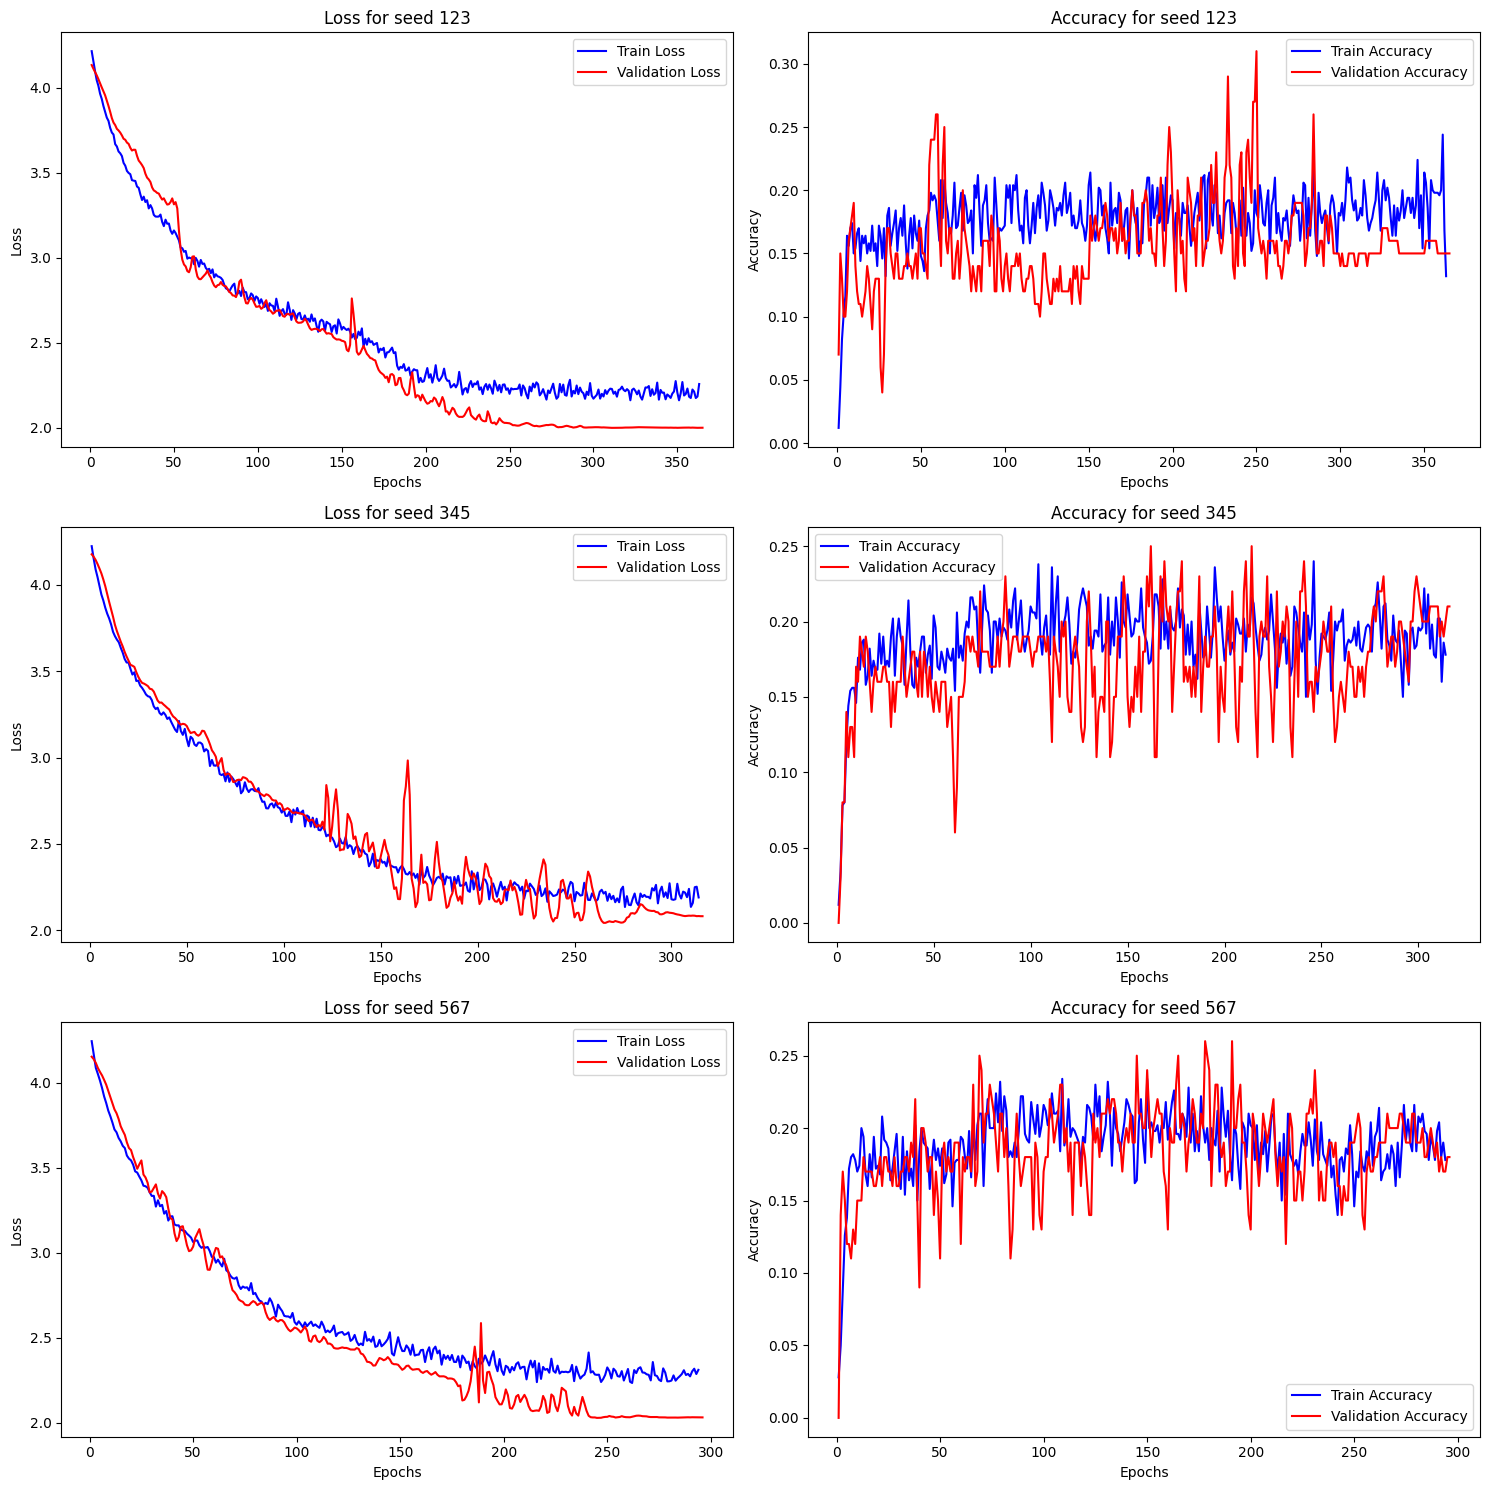

In [ ]:
plot_results(results)

In [ ]:
best_val_accuracies = np.array([metrics["best_val_accuracy"] for _, metrics in results.items()])
mean_accuracy = np.mean(best_val_accuracies)
std_dev_accuracy = np.std(best_val_accuracies)
print(f"Best Validation Accuracies: {best_val_accuracies}")
print(f"Mean Best Validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Best Validation Accuracies: {std_dev_accuracy:.4f}")

Best Validation Accuracies: [0.31 0.25 0.26]
Mean Best Validation Accuracy: 0.2733
Standard Deviation of Best Validation Accuracies: 0.0262


## 3.1 Baseline Performace

In [ ]:
class GCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True, residual=False):
        super(GCNBlock, self).__init__()

        self.conv = GCNConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm
        self.residual = residual

        if self.residual:
            self.res_connection = torch.nn.Linear(in_channels, out_channels, bias=False)

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        res = x
        x = self.conv(x, edge_index)
        if self.residual:
            x += self.res_connection(res)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class ResGCN(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(ResGCN, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm'], residual=True))

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(layer_configs[-1]['out_channels'], 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, num_classes),
        )

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.mlp(x)
        return x

layer_configs = [
    {"out_channels": 128, "dropout_rate": 0.5, "batch_norm": True, "residual": True},
    {"in_channels": 128, "out_channels": 128, "dropout_rate": 0.5, "batch_norm": True, "residual": True}
]


In [ ]:
DATA_PERTURB_SEEDS = [123, 345, 567]  # 3 distinct seeds for data perturbations

# hyperparameters
train_size = 500
test_size = 100
batch_size = 256
learning_rate = 0.001
weight_decay = 0.001
scheduler = True
schedule_patience = 15

# Load dataset
dataset = TUDataset(name='ENZYMES', root='data/TUDataset')
dataset.use_node_attr = False
dataset.use_edge_attr = False

results = {}

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = ResGCN(dataset.num_features, layer_configs, dataset.num_classes)
    model_wrapper = GNNWrapper(dataset, model, learning_rate=learning_rate, use_lr_scheduler = scheduler,
                                schedule_patience = schedule_patience, weight_decay=weight_decay)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor=f"val/loss", mode="min", patience=50)

    # Instantiate Pytorch Lightning trainer
    trainer = pl.Trainer(
      accelerator="cpu",
      max_epochs=300,
      callbacks=[early_stopping],
      check_val_every_n_epoch=1,
    )

    # Train the model
    trainer.fit(model_wrapper, train_loader, test_loader)
    trainer.validate(model_wrapper, test_loader)

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": model_wrapper.epoch_train_loss,
        "train_accuracy": model_wrapper.epoch_train_accuracy,
        "val_loss": model_wrapper.epoch_val_loss,
        "val_accuracy": model_wrapper.epoch_val_accuracy,
        "best_val_accuracy": max(model_wrapper.epoch_val_accuracy)
      }

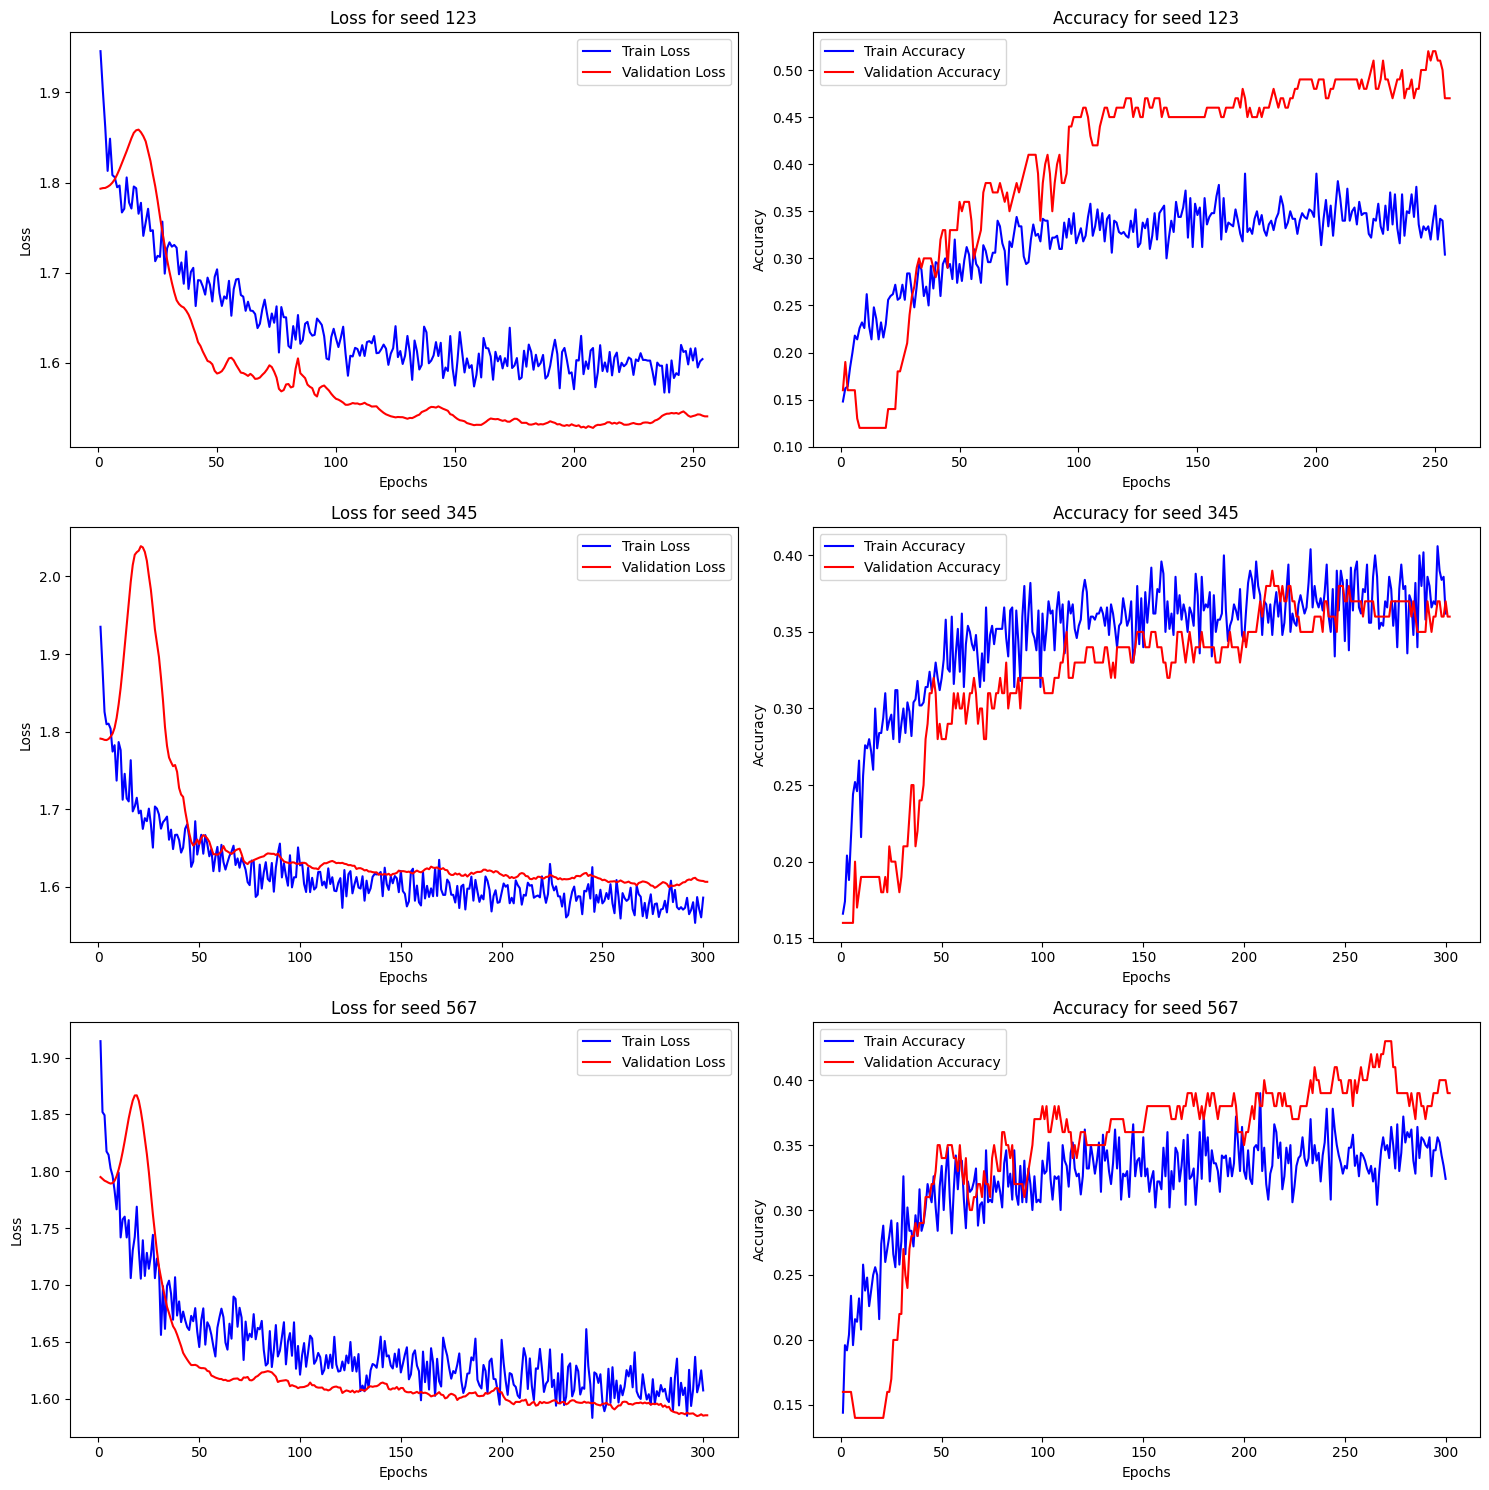

In [ ]:
plot_results(results)

In [ ]:
best_val_accuracies = np.array([metrics["best_val_accuracy"] for _, metrics in results.items()])
mean_accuracy = np.mean(best_val_accuracies)
std_dev_accuracy = np.std(best_val_accuracies)
print(f"Best Validation Accuracies: {best_val_accuracies}")
print(f"Mean Best Validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Best Validation Accuracies: {std_dev_accuracy:.4f}")

Best Validation Accuracies: [0.52 0.39 0.43]
Mean Best Validation Accuracy: 0.4467
Standard Deviation of Best Validation Accuracies: 0.0544


## 3.2 Push Performance

# New Section

In [ ]:
DATA_PERTURB_SEEDS = [123, 345, 567]  # 3 distinct seeds for data perturbations

# hyperparameters
train_size = 500
test_size = 100
batch_size = 256
learning_rate = 0.001
weight_decay = 0.005
scheduler = True
schedule_patience = 10

# Load dataset
dataset = TUDataset(name='ENZYMES', root='data/TUDataset')
dataset.use_node_attr = True
dataset.use_edge_attr = True
dataset.process()

results = {}

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = ResGCN(dataset.num_features, layer_configs, dataset.num_classes)
    model_wrapper = GNNWrapper(dataset, model, learning_rate=learning_rate, use_lr_scheduler = scheduler,
                                schedule_patience = schedule_patience, weight_decay=weight_decay)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor=f"val/loss", mode="min", patience=50)

    # Instantiate Pytorch Lightning trainer
    trainer = pl.Trainer(
      accelerator="cpu",
      max_epochs=300,
      callbacks=[early_stopping],
      check_val_every_n_epoch=1,
    )

    # Train the model
    trainer.fit(model_wrapper, train_loader, test_loader)
    trainer.validate(model_wrapper, test_loader)

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": model_wrapper.epoch_train_loss,
        "train_accuracy": model_wrapper.epoch_train_accuracy,
        "val_loss": model_wrapper.epoch_val_loss,
        "val_accuracy": model_wrapper.epoch_val_accuracy,
        "best_val_accuracy": max(model_wrapper.epoch_val_accuracy)
      }

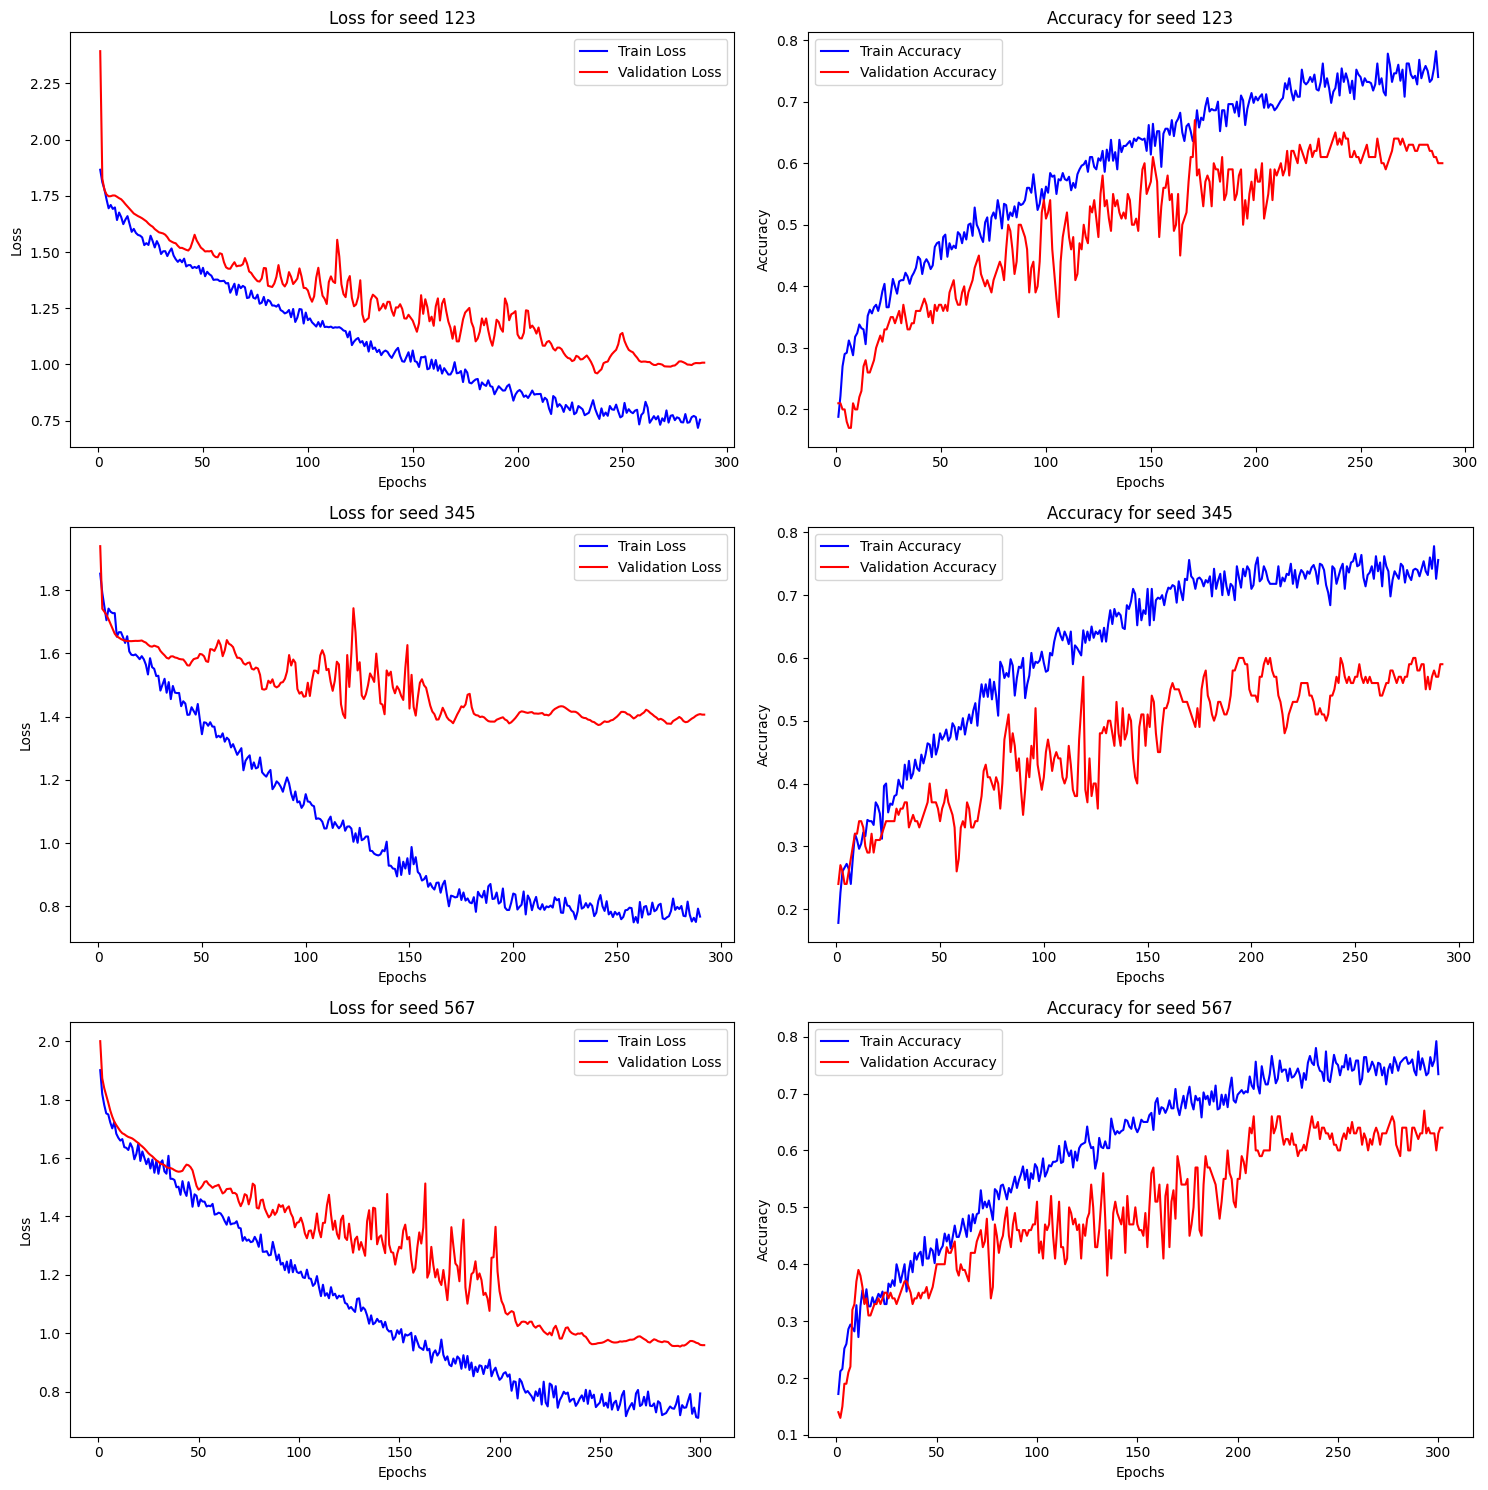

In [ ]:
plot_results(results)

In [ ]:
best_val_accuracies = np.array([metrics["best_val_accuracy"] for _, metrics in results.items()])
mean_accuracy = np.mean(best_val_accuracies)
std_dev_accuracy = np.std(best_val_accuracies)
print(f"Best Validation Accuracies: {best_val_accuracies}")
print(f"Mean Best Validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Best Validation Accuracies: {std_dev_accuracy:.4f}")

Best Validation Accuracies: [0.67 0.6  0.67]
Mean Best Validation Accuracy: 0.6467
Standard Deviation of Best Validation Accuracies: 0.0330


## 3.3 State of the Art

In [ ]:
class SAGEBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True, residual=True):
        super(SAGEBlock, self).__init__()

        self.conv = SAGEConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm
        self.residual = residual

        if self.residual:
            self.res_connection = torch.nn.Linear(in_channels, out_channels, bias=False)

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        res = x
        x = self.conv(x, edge_index)
        if self.residual:
            x += self.res_connection(res)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x


class ResSAGE_LSTM(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(ResSAGE_LSTM, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = SAGEBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(SAGEBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

        self.lstm_pooling = LSTM(input_size=layer_configs[-1]['out_channels'], hidden_size=128, batch_first=True)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_classes),
        )

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)

        # Process each graph in the batch individually and use LSTM on its nodes
        pooled_outputs = []
        for graph_id in batch.unique():
            # Extract nodes for this graph
            nodes_for_graph = x[batch == graph_id]

            # Add an extra dimension for batch (LSTM expects 3D input: batch x seq x feature)
            nodes_for_graph = nodes_for_graph.unsqueeze(0)

            # LSTM pooling
            out, (hn, cn) = self.lstm_pooling(nodes_for_graph)

            # Use the last LSTM output for this graph as its pooled representation
            pooled_representation = out[0, -1, :]
            pooled_outputs.append(pooled_representation)

        # Concatenate pooled representations for all graphs to match batch size
        x_pooled = torch.stack(pooled_outputs)

        x = self.mlp(x_pooled)
        return x

layer_configs = [
    {"out_channels": 256, "dropout_rate": 0.5, "batch_norm": True, 'residual': True},
    {"in_channels": 256, "out_channels": 128, "dropout_rate": 0.5, "batch_norm": True, 'residual': True}
]

In [ ]:
DATA_PERTURB_SEEDS = [123, 345, 567]  # 3 distinct seeds for data perturbations

# hyperparameters
train_size = 500
test_size = 100
batch_size = 128
learning_rate = 0.001
weight_decay = 0.001
scheduler = True
schedule_patience = 15

# Load dataset
dataset = TUDataset(name='ENZYMES', root='data/TUDataset')
dataset.use_node_attr = False
dataset.use_edge_attr = False

results = {}

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = ResSAGE_LSTM(dataset.num_features, layer_configs, dataset.num_classes)
    model_wrapper = GNNWrapper(dataset, model, learning_rate=learning_rate, use_lr_scheduler = scheduler,
                                schedule_patience = schedule_patience, weight_decay=weight_decay)


    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor=f"val/loss", mode="min", patience=50)

    # Instantiate Pytorch Lightning trainer
    trainer = pl.Trainer(
      accelerator="cpu",
      max_epochs=300,
      callbacks=[early_stopping],
      check_val_every_n_epoch=1,
    )


    # Train the model
    trainer.fit(model_wrapper, train_loader, test_loader)
    trainer.validate(model_wrapper, test_loader)

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": model_wrapper.epoch_train_loss,
        "train_accuracy": model_wrapper.epoch_train_accuracy,
        "val_loss": model_wrapper.epoch_val_loss,
        "val_accuracy": model_wrapper.epoch_val_accuracy,
        "best_val_accuracy": max(model_wrapper.epoch_val_accuracy)
      }

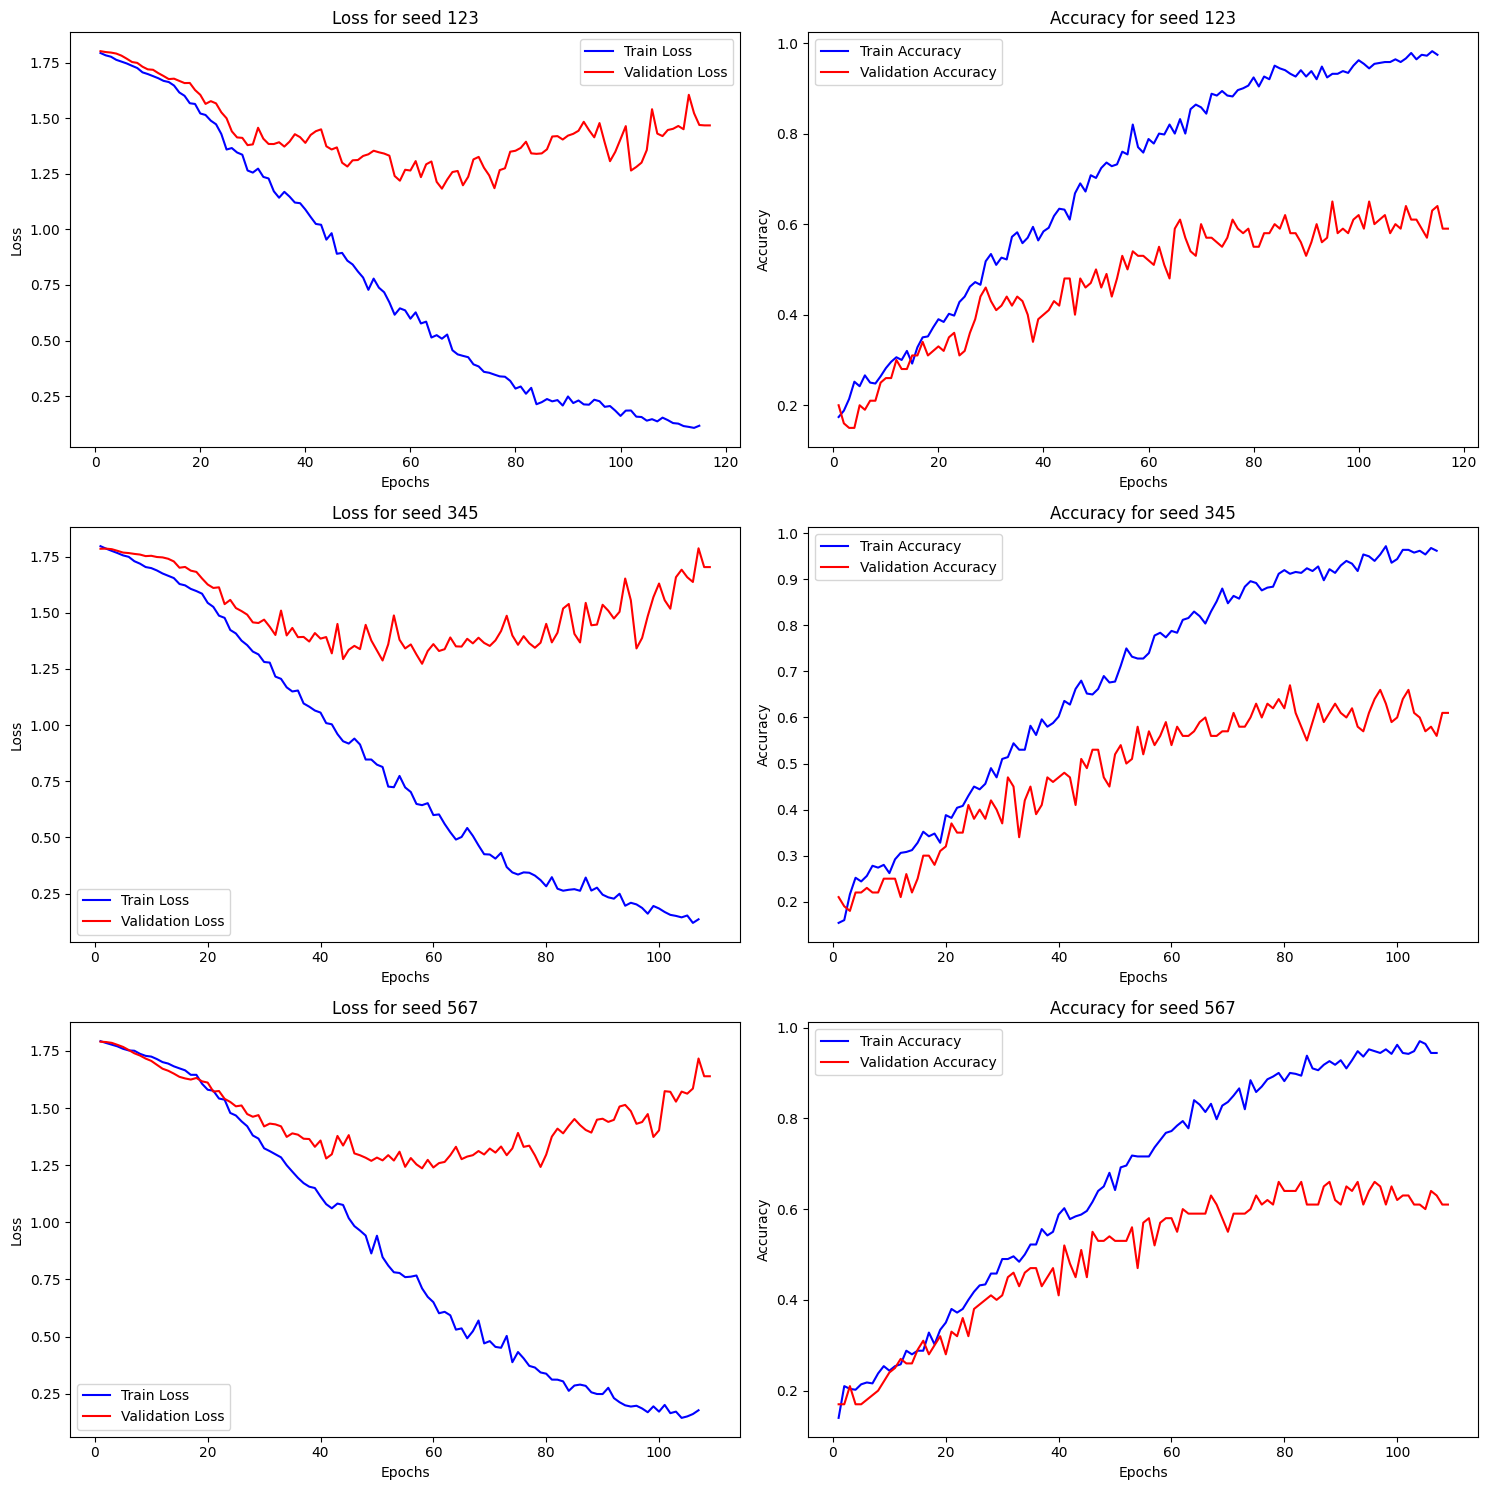

In [ ]:
plot_results(results)

In [ ]:
best_val_accuracies = np.array([metrics["best_val_accuracy"] for _, metrics in results.items()])
mean_accuracy = np.mean(best_val_accuracies)
std_dev_accuracy = np.std(best_val_accuracies)
print(f"Best Validation Accuracies: {best_val_accuracies}")
print(f"Mean Best Validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Best Validation Accuracies: {std_dev_accuracy:.4f}")

Best Validation Accuracies: [0.65 0.67 0.66]
Mean Best Validation Accuracy: 0.6600
Standard Deviation of Best Validation Accuracies: 0.0082


In [ ]:
DATA_PERTURB_SEEDS = [123, 345, 567]  # 3 distinct seeds for data perturbations

# hyperparameters
train_size = 500
test_size = 100
batch_size = 128
learning_rate = 0.001
weight_decay = 0.001
scheduler = True
schedule_patience = 15

# Load dataset
dataset = TUDataset(name='ENZYMES', root='data/TUDataset')
dataset.use_node_attr = True
dataset.use_edge_attr = True
dataset.process()
print(dataset.x.shape)

results = {}

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = ResSAGE_LSTM(dataset.num_features, layer_configs, dataset.num_classes)
    model_wrapper = GNNWrapper(dataset, model, learning_rate=learning_rate, use_lr_scheduler = scheduler,
                                schedule_patience = schedule_patience, weight_decay=weight_decay)


    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor=f"val/loss", mode="min", patience=50)

    # Instantiate Pytorch Lightning trainer
    trainer = pl.Trainer(
      accelerator="cpu",
      max_epochs=300,
      callbacks=[early_stopping],
      check_val_every_n_epoch=1,
    )


    # Train the model
    trainer.fit(model_wrapper, train_loader, test_loader)
    trainer.validate(model_wrapper, test_loader)

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": model_wrapper.epoch_train_loss,
        "train_accuracy": model_wrapper.epoch_train_accuracy,
        "val_loss": model_wrapper.epoch_val_loss,
        "val_accuracy": model_wrapper.epoch_val_accuracy,
        "best_val_accuracy": max(model_wrapper.epoch_val_accuracy)
      }

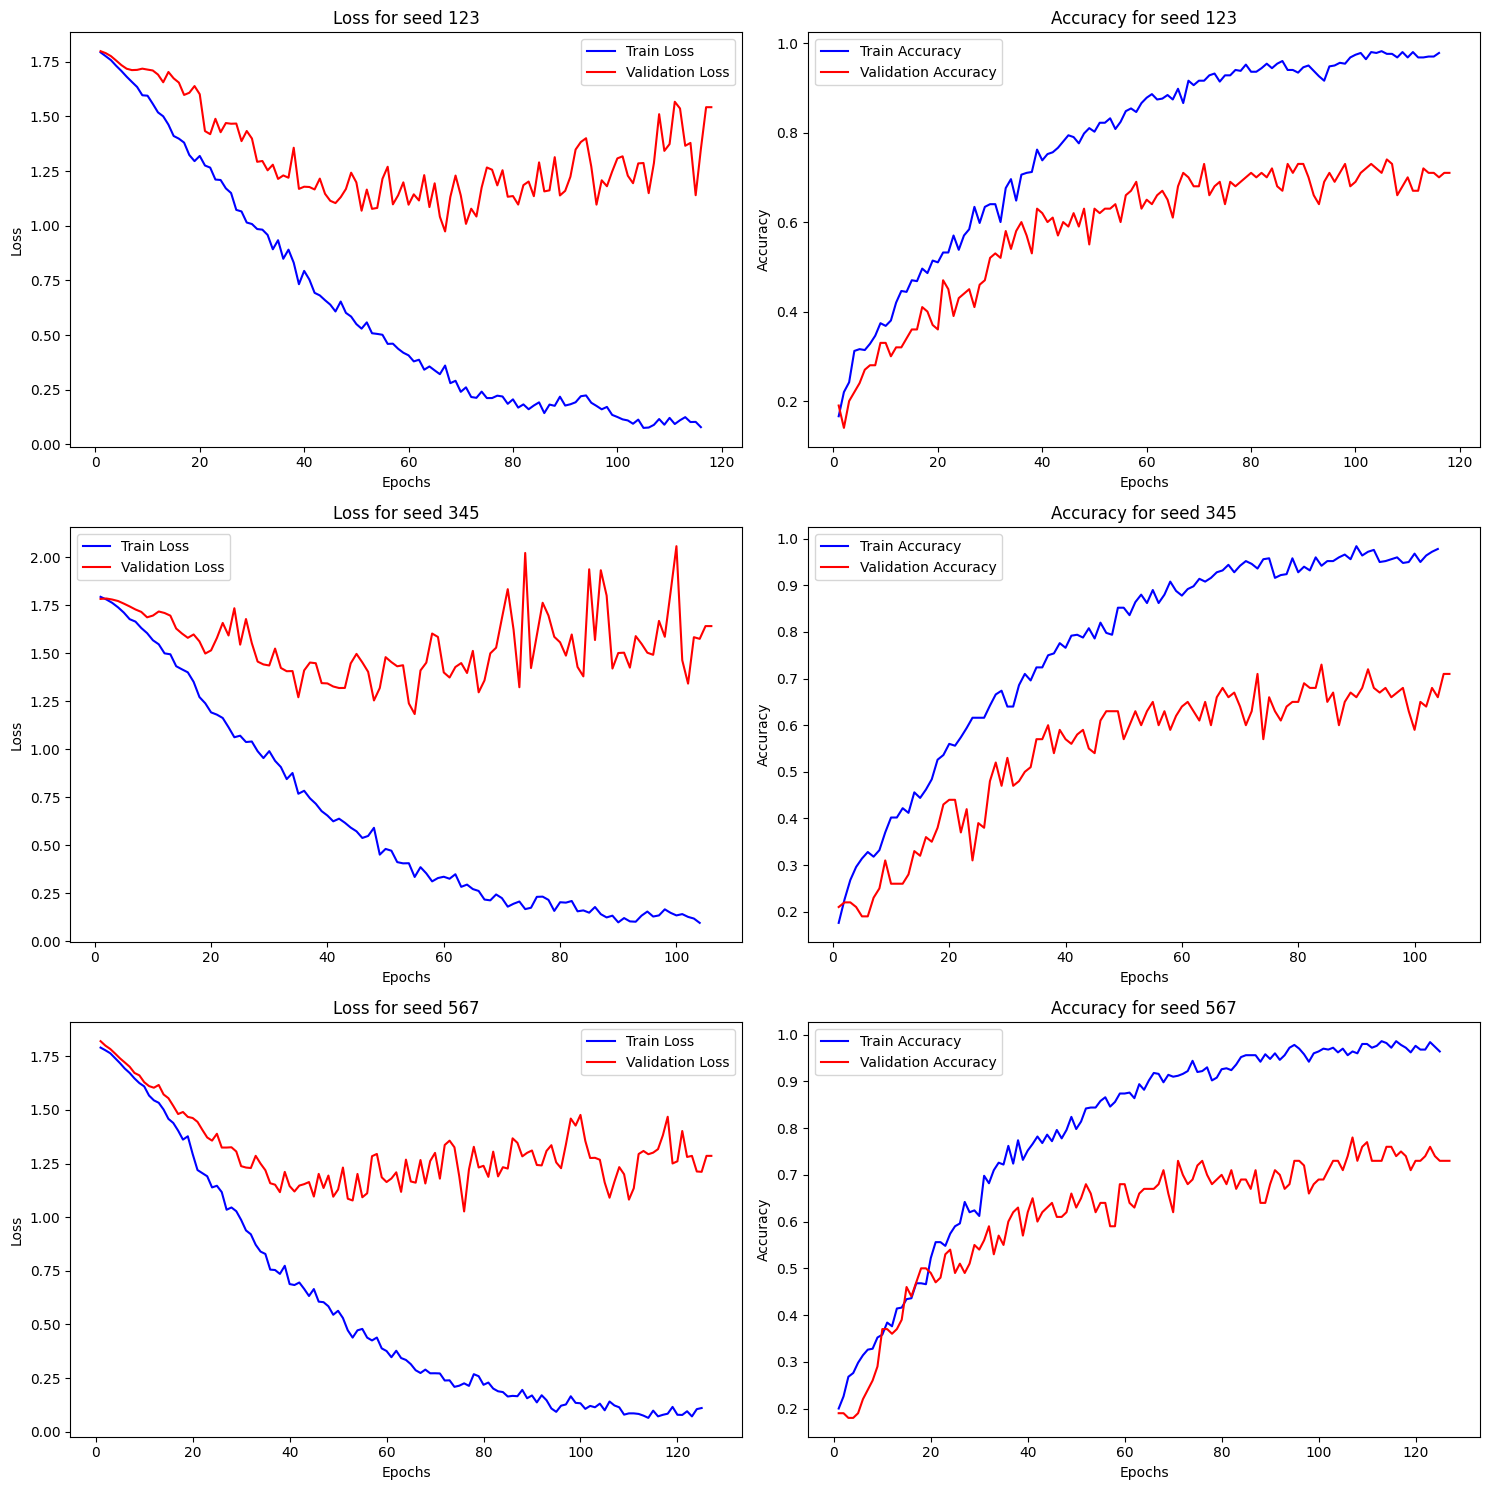

In [ ]:
plot_results(results)

In [ ]:
best_val_accuracies = np.array([metrics["best_val_accuracy"] for _, metrics in results.items()])
mean_accuracy = np.mean(best_val_accuracies)
std_dev_accuracy = np.std(best_val_accuracies)
print(f"Best Validation Accuracies: {best_val_accuracies}")
print(f"Mean Best Validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Best Validation Accuracies: {std_dev_accuracy:.4f}")

Best Validation Accuracies: [0.74 0.73 0.78]
Mean Best Validation Accuracy: 0.7500
Standard Deviation of Best Validation Accuracies: 0.0216
